In [1]:
import config, data_info, data_plot

In [2]:
import seaborn as sns
import sqlite3
import pandas as pd

In [3]:
cnx = sqlite3.connect(config.PATH_DB)

In [4]:
def group_query(var):
  return f'SELECT {var}, count({var}) as count FROM partos group by {var}'

In [5]:
pd.read_sql_query(group_query('deslocou'), cnx).sort_values(by='count', ascending=False)

,deslocou,count
1,1,2340819
0,0,151466


In [6]:
pd.read_sql_query(group_query('procedimento'), cnx).sort_values(by='count', ascending=False)

,procedimento,count
1,PARTO NORMAL,1434334
0,PARTO CESARIANO,1057951


In [7]:
pd.read_sql_query(group_query('ano'), cnx).sort_values(by='count', ascending=False)

,ano,count
0,2019,1271344
1,2020,1220941


<AxesSubplot:xlabel='idade', ylabel='count'>

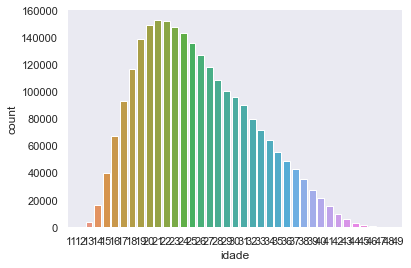

In [8]:
idade = pd.read_sql_query(group_query('idade'), cnx)#.sort_values(by='count', ascending=False)
sns.barplot(x='idade', y='count', data=idade)

In [9]:
pd.read_sql_query(group_query('raca_cor'), cnx).sort_values(by='count', ascending=False)

,raca_cor,count
0,Amarela,1476722
1,Branca,769699
4,Preta,131969
3,Parda,94820
2,Indígena,19075


In [10]:
pd.read_sql_query(group_query('res_regiao'), cnx).sort_values(by='count', ascending=False)

,res_regiao,count
3,Sudeste,930105
1,Nordeste,720084
4,Sul,348511
2,Norte,305237
0,Centro-Oeste,188348


In [11]:
pd.read_sql_query(group_query('res_uf'), cnx).sort_values(by='count', ascending=False)

,res_uf,count
25,SP,499112
10,MG,227222
4,BA,200635
18,RJ,153795
22,RS,128041
17,PR,127036
13,PA,124981
15,PE,102337
5,CE,101844
2,AM,98712


In [12]:
pd.read_sql_query(group_query('res_regiao_saude'), cnx).sort_values(by='count', ascending=False)

,res_regiao_saude,count
211,3501,113743
207,3305,106730
7,1301,56476
222,3512,53990
213,3503,45811
...,...,...
323,5205,606
75,2215,602
32,1602,451
2,1103,276


In [13]:
pd.read_sql_query(group_query('int_regiao'), cnx).sort_values(by='count', ascending=False)

,int_regiao,count
3,Sudeste,929208
1,Nordeste,722253
4,Sul,348062
2,Norte,304936
0,Centro-Oeste,187826


In [14]:
pd.read_sql_query(group_query('int_uf'), cnx).sort_values(by='count', ascending=False)

,int_uf,count
25,SP,497962
10,MG,227275
4,BA,200267
18,RJ,154322
22,RS,127885
17,PR,126438
13,PA,123258
15,PE,102482
5,CE,101285
2,AM,98705


In [15]:
pd.read_sql_query(group_query('int_regiao_saude'), cnx).sort_values(by='count', ascending=False)

,int_regiao_saude,count
211,3501,115400
207,3305,106075
7,1301,57433
222,3512,53999
171,3101,44986
...,...,...
75,2215,101
133,2801,39
42,1710,35
38,1706,6
